# Feature selection
-----
- z-stack Movies were prepared from the merged tilescan images
- We are now ready for feature extraction from the movies


In [1]:
%matplotlib notebook

# Dependencies

import os
import cv2
import merging_functions as mf
import numpy as np
import tracker as tr

from matplotlib import pyplot as plt

In [2]:
# Go through each timepoint and each frame to collect the pixel and their locations that exceeds the threshold
def get_image_sequence(video_folder, exp_name, acq_name, t_str):
    # Run through a single timepoint
    video_path = os.path.join(video_folder, f"{exp_name}_{acq_name}_{t_str}.avi")

    # Video capture object
    vidcap = cv2.VideoCapture(video_path)

    # Frame properties
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

    img_seq = np.zeros((frame_height, frame_width, frame_count), np.uint8)
    for fix in range(frame_count):
        # Read frmae
        success,frame = vidcap.read()
        # Convert to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img_seq[:,:,fix] = frame_gray
        
    return img_seq


In [3]:
exp_name = "EQ59_Glu_03142021"
acq_name = "TileScan_12-24h_xyzt"

exp_folder = os.path.join("E:", "Tolga", exp_name)
video_folder = os.path.join(exp_folder, "Videos_Marked", f"{exp_name}_{acq_name}")


metadata = mf.collect_metadata(exp_folder, exp_name, acq_name)

In [6]:
def collect_radial_data(roi_img):
    height, width = roi_img.shape
    centerx = np.int32(width/2)
    centery = np.int32(height/2)
    Rar_pxl = np.arange(5,width/2, dtype=np.int32)
    central_sum = np.zeros_like(Rar_pxl)
    for Rix in range(len(Rar_pxl)):
        radius = Rar_pxl[Rix]
        circle_img = np.zeros((height,width), np.uint8)
        cv2.circle(circle_img,(centerx,centery), radius,1,thickness=-1)
        masked_data = cv2.bitwise_and(roi_img, roi_img, mask=circle_img)

        central_sum[Rix] = masked_data.sum()/radius/radius
        
    return Rar_pxl, central_sum

## Choose center and max radius
At the end, calculate the ROI from the center point +- radius*1.1 square.

<IPython.core.display.Javascript object>


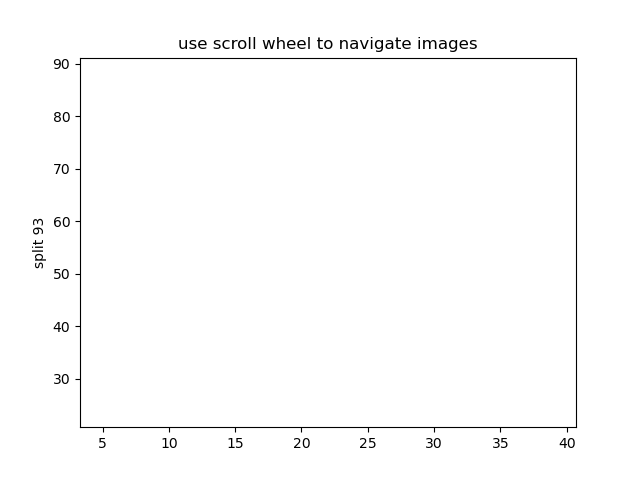

In [7]:
centerx = 115
centery = 200
radius = 20

zsz = metadata["dimensions"]["Z"]["NumberOfElements"]
frame_height = 512
frame_width = 512

roix = np.array([0,frame_width])
roiy = np.array([0,frame_height])
roix = np.array([centerx - radius*2, centerx + radius*2], dtype=np.int32)
roiy = np.array([centery - radius*2, centery + radius*2], dtype=np.int32)

t_str = "t5"
zar = np.arange(0,zsz)
img_seq = get_image_sequence(video_folder, exp_name, acq_name, t_str)
roi_image = img_seq[roix[0]:roix[1], roiy[0]:roiy[1], 0]
height,width = roi_image.shape
img_seq_maxz = np.zeros((height, width, zsz)) # numpy 3d array image sequence to track max intensity images
img_maxz = np.zeros_like(roi_image)
plt_seq = np.zeros((2,np.int32(len(roi_image)/2 - 5), zsz))
for zix in range(zsz):
    roi_image = img_seq[roiy[0]:roiy[1], roix[0]:roix[1], zix]
    blurred_image = cv2.GaussianBlur(roi_image, (5,5), 0).astype(np.uint8)
    equalized_image = cv2.equalizeHist(blurred_image)
    ret, threshold_image = cv2.threshold(equalized_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
#     # Use threshold_image for manually measuring the radius and the center
#     img_seq_maxz[:, :, tix] = threshold_image
    # Use blurred_image for nice plots
#     cv2.circle(blurred_image, (centerx, centery), radius, (255,255,255), 1)
    img_seq_maxz[:, :, zix] = roi_image
    img_maxz += roi_image
                   
    rar, central_avg = collect_radial_data(roi_image)
    plt_seq[0,:,zix] = rar.copy()
    plt_seq[1,:,zix] = central_avg.copy()
        

# Plot the image sequence in a figure
fig_maxint_img, ax = plt.subplots()
# tracker = tr.IndexTracker(ax, img_seq_maxz, "image", 70)#, args_dict)
tracker = tr.IndexTracker(ax, plt_seq, "line", 70)
fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()


### Replot images with tracker to see the ROI images

In [ ]:
fig,ax = plt.subplots()
plt = ax.plot([1,2,3], [2,3,4])

In [ ]:
plt[0].set_data([1,2,3], [4,5,6])